In [57]:
import numpy 
import os
import pathlib
import shutil
import qiskit
import matplotlib.pyplot as plt
import pandas
from datetime import datetime
from qiskit_ibm_runtime import QiskitRuntimeService

In [20]:
service = QiskitRuntimeService(instance="ibm-q/open/main")

TOKEN = "611c90c49ec2bdca1945f0fb99f78cbe6e841084394a4fecba30ff27d59fb3909a5b6eef815892d40e5bc76eaf903ae119b11b378547b0ddf875f0a4ac78710a"

DATE = str(datetime.today())[:10].replace(":","-")

BACKENDS = ["ibm_kyiv","ibm_sherbrooke","ibm_brisbane"]

In [33]:
def get_gate_error():

    output = []

    for be in BACKENDS:
        backend = service.backend(be)
        basis_set = backend.properties().gates
        cm = backend.coupling_map
        nqubits = backend.num_qubits
        qproperties = backend.qubit_properties(list(range(nqubits)))
        backend_props = backend.properties()
        for basis_gate in backend.configuration().basis_gates:
            for gate_props in backend_props.gates:
                data = gate_props.to_dict()
               
                if data['gate'] == basis_gate:
                    #output[basis_gate] = {data['qubits']:param['value'] for param in data['parameters']} # if param['name'] == 'gate_error'}
                    for param in data['parameters']:
                        if param['name'] == 'gate_error':
                            # name: MM-DD-YR.csv
                            # header: backend, basis_gate, q1, q2, error, 
                            output.append({
                                "backend":backend.name,
                                "basis_gate": basis_gate,
                                "q1": data['qubits'][0], 
                                "q2": data['qubits'][1] if len(data['qubits']) >1 else None, 
                                "error": param['value']})
                            
                            # print(backend().name,basis_gate,"gate_error on", data['qubits'], param['value']) 

    
    df = pandas.DataFrame(output)
    print(df)

    return df

In [34]:
def save_data(data:pandas.DataFrame, cwd):
    fname = DATE+ ".csv"

    data.to_csv(fname)
    # where we are


    # file to move
    src = cwd +"/" +fname

    pathlib.Path(cwd+"/error_data").mkdir(parents=True, exist_ok=True)
    dst = cwd +"/error_data/" + fname
    
    shutil.move(src, dst)
    pass

In [35]:
def grab_data():
    cwd = os.getcwd()
    data = get_gate_error()
    print(data[data["backend"]=="ibm_sherbrooke"])
    save_data(data, cwd)
    print("data saved")
grab_data()

           backend basis_gate   q1     q2     error
0         ibm_kyiv        ecr   96   95.0  0.007146
1         ibm_kyiv        ecr   67   68.0  0.012149
2         ibm_kyiv        ecr  108  112.0  0.008776
3         ibm_kyiv        ecr   17   12.0  0.033686
4         ibm_kyiv        ecr    8    9.0  1.000000
...            ...        ...  ...    ...       ...
1951  ibm_brisbane          x  122    NaN  0.000286
1952  ibm_brisbane          x  123    NaN  0.000446
1953  ibm_brisbane          x  124    NaN  0.000175
1954  ibm_brisbane          x  125    NaN  0.000314
1955  ibm_brisbane          x  126    NaN  0.000149

[1956 rows x 5 columns]
             backend basis_gate   q1     q2     error
652   ibm_sherbrooke        ecr   41   40.0  0.021955
653   ibm_sherbrooke        ecr   99  100.0  0.008324
654   ibm_sherbrooke        ecr   78   77.0  0.011001
655   ibm_sherbrooke        ecr   17   12.0  0.005017
656   ibm_sherbrooke        ecr    8    9.0  0.014544
...              ...       

# Data Analsys
Here we want to search for "problem children" qubits these are qubits that are consistently (tending to be) above the avg gate error of their peers. We can compute this two different ways, but they both come back to the same idea: averageing above the mean significantly. Where these methods differ is what mean we use. 
1. In our first option we will use the average mean that VF2layoutPass uses for 1 qubit and 2 qubit gate errors as our baseline + some arbitrary threshold (+5%?) to identify the worst qubits.
2. In the latter we can create our own running average of the 1 qubit & 2 qubit gate errors (even going so far as deriving these averages in each basis gate dimension rather than combining them first), before ultimately adding some threshold (+5%) to identify the worst qubits.

In a single day this gives some information, but by aggregating we can hope to see a trend / outlier qubits that we can identify as troublesome. While the database acts as a scoreboard, what we really want is a rolling 'employee of the month' rolling window, or decaying weights system to account for active calibration efforts by site maintainers.  


In [36]:
def load_data():
    
    cwd = os.getcwd()
    print(cwd)
    return os.listdir(cwd + "/error_data/")

In [53]:
def get_filedata(fnames:list[str]):
    all_data = {}
    print("getting data from: ", end="")
    for fname in fnames:
        all_data[fname] = (pandas.read_csv("error_data/" + fname))
        print(fname, end=", ")
    print()
    return all_data

def zerror(form:pandas.DataFrame):
    base = pandas.DataFrame.copy(form)
    base["error"] = base["error"].mul(0)
    return base

def gate_avg(gate:str,avg_error:pandas.DataFrame):
    selection = avg_error[avg_error["basis_gate"]==gate]
    gate_average_error = selection["error"].sum() / len(selection)
    return gate_average_error

def two_gate_avg(avg_error:pandas.DataFrame):
    selection = avg_error[~avg_error["q2"].isnull()]
    dos = selection["error"].sum() / len(selection)
    return dos

def single_gate_avg(avg_error:pandas.DataFrame):
    selection = avg_error[avg_error["q2"].isnull()]
    uno = selection["error"].sum() / len(selection)
    return uno

def rolling_avg(data, window_size:int):
    """ Given a set of data and a window size, select the newest X entries to be included in the windowed average"""
    pass

def _default_weight():
    return 1

def weighted_avg(data,weighting_func=_default_weight):
    """Given a set of data and a weighting function, apply weights to the data and find the average"""
    pass

def machine_data(name:str,data:dict[pandas.DataFrame]):
    filtered_df = data.copy()
    for key, day in data.items():
        filtered_df[key] = day[day["backend"]==name]
    return filtered_df
    
def calc_avgs(data:dict[pandas.DataFrame]):

    # broken down by basis set gates
    gate_averages = {}
    blank = zerror(data[list(data.keys())[0]])
    
    gate_error_average = 0
    for fname,day in data.items():
        #TODO: fix this naive solution for one that checks the keys
        blank["error"] += day["error"]
        
    blank["error"] = blank["error"].div(len(data))

    for gate in blank["basis_gate"].unique():
        gate_averages[gate] = gate_avg(gate, blank)
    #print(gate_averages)
    #print(sum(list(gate_averages.values())), len(gate_averages))
    #gate_error_average = sum(list(gate_averages.values()))/ len(gate_averages)
    gate_averages["Dos"] = two_gate_avg(blank)
    gate_averages["Uno"] = single_gate_avg(blank)
    
    print("gate_avg:\n",gate_averages,"\n based on the Physical Gate Avgs:\n",blank)
    return gate_averages, blank 


In [54]:
# Averages across all machines, baseline should assume all machines have same averages 
# (this is an assumption that should be challenged)

data = get_filedata(load_data())
print("global")
_global_averages = calc_avgs(data)

machine_specific = {}
for machine in BACKENDS:
    print("\n",machine)
    _mdata = machine_data(machine, data)
    machine_specific[machine] = calc_avgs(_mdata)

/pool/alexb/qcs
getting data from: 2025-03-17.csv, 2025-03-19.csv, 2025-03-18.csv, 
global
gate_avg:
 {'ecr': 0.03808550889547033, 'id': 0.0007687255450318028, 'rz': 0.0, 'sx': 0.0007687255450318028, 'x': 0.0007687255450318028, 'Dos': 0.03808550889547033, 'Uno': 0.0005765441587738522} 
 based on the Physical Gate Avgs:
       Unnamed: 0       backend basis_gate   q1     q2     error
0              0      ibm_kyiv        ecr   96   95.0  0.007000
1              1      ibm_kyiv        ecr   67   68.0  0.012488
2              2      ibm_kyiv        ecr  108  112.0  0.011483
3              3      ibm_kyiv        ecr   17   12.0  0.036222
4              4      ibm_kyiv        ecr    8    9.0  1.000000
...          ...           ...        ...  ...    ...       ...
1951        1951  ibm_brisbane          x  122    NaN  0.000286
1952        1952  ibm_brisbane          x  123    NaN  0.000446
1953        1953  ibm_brisbane          x  124    NaN  0.000175
1954        1954  ibm_brisbane        

False
False
      2025-03-17.csv  2025-03-18.csv  2025-03-19.csv
0           0.006707        0.007146        0.007146
1           0.013165        0.012149        0.012149
2           0.016895        0.008776        0.008776
3           0.041294        0.033686        0.033686
4           1.000000        1.000000        1.000000
...              ...             ...             ...
1951        0.000286        0.000286        0.000286
1952        0.000446        0.000446        0.000446
1953        0.000175        0.000175        0.000175
1954        0.000314        0.000314        0.000314
1955        0.000149        0.000149        0.000149

[1956 rows x 3 columns]


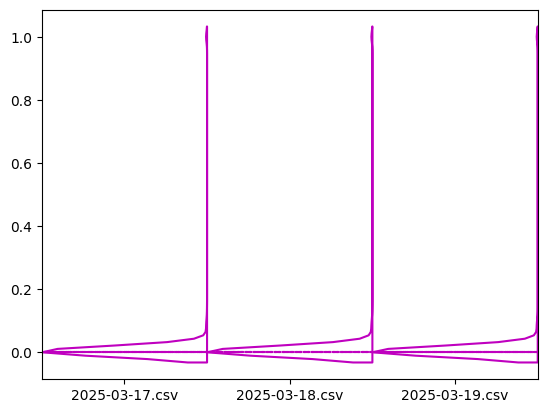

False
False
      2025-03-17.csv  2025-03-18.csv  2025-03-19.csv
0           0.006707        0.007146        0.007146
1           0.013165        0.012149        0.012149
2           0.016895        0.008776        0.008776
3           0.041294        0.033686        0.033686
4           1.000000        1.000000        1.000000
...              ...             ...             ...
1951        0.000286        0.000286        0.000286
1952        0.000446        0.000446        0.000446
1953        0.000175        0.000175        0.000175
1954        0.000314        0.000314        0.000314
1955        0.000149        0.000149        0.000149

[1956 rows x 3 columns]


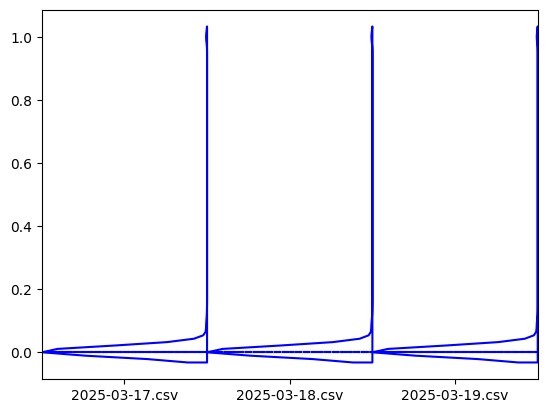

False
False
      2025-03-17.csv  2025-03-18.csv  2025-03-19.csv
0           0.006707        0.007146        0.007146
1           0.013165        0.012149        0.012149
2           0.016895        0.008776        0.008776
3           0.041294        0.033686        0.033686
4           1.000000        1.000000        1.000000
...              ...             ...             ...
1951        0.000286        0.000286        0.000286
1952        0.000446        0.000446        0.000446
1953        0.000175        0.000175        0.000175
1954        0.000314        0.000314        0.000314
1955        0.000149        0.000149        0.000149

[1956 rows x 3 columns]


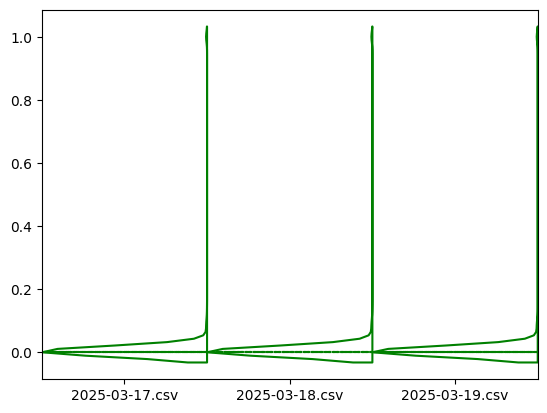

In [121]:
import seaborn as sn

## DID NOT PAN OUT IN TIME :(
def plot_averages(all_data):
    """
    Given the global averages plot the gate error averages as points, and the average of averages as lines, maybe look at super imposing a distribution from the mean & stdev.?
    """
    def fmt_data(_data):
        d = {}
        __d = _data.copy()
        
        for backend in BACKENDS:
            d[backend] = pandas.DataFrame({day:datum["error"] for day, datum in __d.items() })
            d[backend] = d[backend].reindex(sorted(d[backend].columns), axis=1)
        return d
        
    data = fmt_data(all_data)
    color_vals = ["m","b","g"]

    for x,backend in enumerate(BACKENDS):
        crt  = data[backend]
        print(crt.isnull().values.any())
        print(numpy.isinf(crt).values.any())
        print(crt)
        sn.violinplot(data=crt, split=True, inner="quart", color=color_vals[x], orient="v",fill=False,width=1, native_scale=False )
        plt.show()    
    
   
    pass

plot_averages(data)

In [ ]:
def problem_children(backend:str, baseline:pandas.DataFrame):
    """ Find the worst (highest error) qubits on the specific backend"""
    pass